# YOLOv5 Sleep-Apnea Classification: Implementation & Evaluation

In [ ]:
# ===========================
# 1. IMPORTS & DRIVE MOUNT
# ===========================

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

from tqdm import tqdm
from IPython.display import display

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
# =========================================
# 2. LOAD & ADAPT PRETRAINED YOLOv5s-CLS
# =========================================

# Load YOLOv5s-CLS v6.1 classification model (~7M params) via torch.hub
hub_model = torch.hub.load(
    'ultralytics/yolov5',
    'custom',
    path='yolov5s-cls.pt',
    source='github'
).to(device)
hub_model.eval()
print("YOLOv5s-CLS loaded.")

# Inspect final classifier block and replace its head for 4 classes
classify_block = hub_model.model.model[-1]
in_features     = classify_block.linear.in_features
print(f"Original head in_features = {in_features}, out_features = {classify_block.linear.out_features}")
classify_block.linear = nn.Linear(in_features, 4)
hub_model.to(device)

# Confirm architecture and parameter count
summary(hub_model.model, input_size=(3, 224, 224))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-6-6 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


YOLOv5s-CLS loaded.
Original head in_features = 1280, out_features = 1000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           3,488
              SiLU-2         [-1, 32, 112, 112]               0
              Conv-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 64, 56, 56]          18,496
              SiLU-5           [-1, 64, 56, 56]               0
              Conv-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           2,080
              SiLU-8           [-1, 32, 56, 56]               0
              Conv-9           [-1, 32, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]           1,056
             SiLU-11           [-1, 32, 56, 56]               0
             Conv-12           [-1, 32, 56, 56]               0
           Conv2d-13         

In [ ]:
# ===============================
# 3. DATA LOADING & TRANSFORMS
# ===============================

base_dir   = "/content/drive/MyDrive/spectrograms_split"
train_dir  = os.path.join(base_dir, "train")
val_dir    = os.path.join(base_dir, "val")
test_dir   = os.path.join(base_dir, "test")
bal_dir    = os.path.join(base_dir, "test_balanced")

# Ensure directories exist
for path in [train_dir, val_dir, test_dir, bal_dir]:
    assert os.path.isdir(path), f"Missing directory: {path}"

# ImageNet-style transforms (224×224 → tensor → normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Load datasets by folder: subfolder names → class labels
train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform)
bal_ds   = datasets.ImageFolder(bal_dir,   transform=transform)

print("Classes:", train_ds.classes)  # e.g. ['mild','moderate','normal','severe']

# DataLoaders
bs, nw = 32, 2
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=nw)
val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=nw)
test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=nw)
bal_loader   = DataLoader(bal_ds,   batch_size=bs, shuffle=False, num_workers=nw)

Classes: ['mild', 'moderate', 'normal', 'severe']


In [ ]:
# =======================================
# 4. TRAINABLE PARAMETERS & OPTIMIZER
# =======================================

model = hub_model
for p in model.parameters():
    p.requires_grad = True

criterion    = nn.CrossEntropyLoss()
optimizer    = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# =======================
# 5. TRAIN & VALIDATE
# =======================

num_epochs = 20
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)                  # logits (bs×4)
        loss    = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1:2d} TRAIN loss: {avg_train_loss:.4f}")
    lr_scheduler.step()

    # Validate
    model.eval()
    val_loss, corr, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]"):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            val_loss += criterion(out, labels).item()
            preds = out.argmax(dim=1)
            corr += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * corr / total
    print(f"Epoch {epoch+1:2d}  VAL loss: {avg_val_loss:.4f} | VAL acc: {val_acc:.2f}%\n")

print("Training complete.")

Epoch 1/20 [TRAIN]: 100%|██████████| 453/453 [03:59<00:00,  1.89it/s]


Epoch  1 TRAIN loss: 1.1099


Epoch 1/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.10it/s]


Epoch  1  VAL loss: 0.9000 | VAL acc: 59.46%



Epoch 2/20 [TRAIN]: 100%|██████████| 453/453 [03:47<00:00,  1.99it/s]


Epoch  2 TRAIN loss: 0.7442


Epoch 2/20 [VAL]: 100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


Epoch  2  VAL loss: 0.6347 | VAL acc: 71.49%



Epoch 3/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.05it/s]


Epoch  3 TRAIN loss: 0.4914


Epoch 3/20 [VAL]: 100%|██████████| 97/97 [00:45<00:00,  2.13it/s]


Epoch  3  VAL loss: 0.3986 | VAL acc: 84.46%



Epoch 4/20 [TRAIN]: 100%|██████████| 453/453 [03:43<00:00,  2.02it/s]


Epoch  4 TRAIN loss: 0.3480


Epoch 4/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.08it/s]


Epoch  4  VAL loss: 0.3567 | VAL acc: 86.33%



Epoch 5/20 [TRAIN]: 100%|██████████| 453/453 [03:38<00:00,  2.07it/s]


Epoch  5 TRAIN loss: 0.2559


Epoch 5/20 [VAL]: 100%|██████████| 97/97 [00:48<00:00,  2.02it/s]


Epoch  5  VAL loss: 0.4479 | VAL acc: 84.36%



Epoch 6/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.05it/s]


Epoch  6 TRAIN loss: 0.1889


Epoch 6/20 [VAL]: 100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


Epoch  6  VAL loss: 0.3180 | VAL acc: 87.65%



Epoch 7/20 [TRAIN]: 100%|██████████| 453/453 [03:43<00:00,  2.03it/s]


Epoch  7 TRAIN loss: 0.1557


Epoch 7/20 [VAL]: 100%|██████████| 97/97 [00:44<00:00,  2.16it/s]


Epoch  7  VAL loss: 0.3725 | VAL acc: 86.46%



Epoch 8/20 [TRAIN]: 100%|██████████| 453/453 [03:44<00:00,  2.02it/s]


Epoch  8 TRAIN loss: 0.1021


Epoch 8/20 [VAL]: 100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


Epoch  8  VAL loss: 0.3319 | VAL acc: 88.04%



Epoch 9/20 [TRAIN]: 100%|██████████| 453/453 [03:41<00:00,  2.05it/s]


Epoch  9 TRAIN loss: 0.0786


Epoch 9/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.03it/s]


Epoch  9  VAL loss: 0.3371 | VAL acc: 88.62%



Epoch 10/20 [TRAIN]: 100%|██████████| 453/453 [03:39<00:00,  2.06it/s]


Epoch 10 TRAIN loss: 0.0733


Epoch 10/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.02it/s]


Epoch 10  VAL loss: 0.3798 | VAL acc: 88.36%



Epoch 11/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.05it/s]


Epoch 11 TRAIN loss: 0.0156


Epoch 11/20 [VAL]: 100%|██████████| 97/97 [00:45<00:00,  2.14it/s]


Epoch 11  VAL loss: 0.2918 | VAL acc: 91.00%



Epoch 12/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.06it/s]


Epoch 12 TRAIN loss: 0.0056


Epoch 12/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.04it/s]


Epoch 12  VAL loss: 0.3102 | VAL acc: 91.26%



Epoch 13/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.05it/s]


Epoch 13 TRAIN loss: 0.0034


Epoch 13/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.06it/s]


Epoch 13  VAL loss: 0.3220 | VAL acc: 91.42%



Epoch 14/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.05it/s]


Epoch 14 TRAIN loss: 0.0022


Epoch 14/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.09it/s]


Epoch 14  VAL loss: 0.3359 | VAL acc: 91.45%



Epoch 15/20 [TRAIN]: 100%|██████████| 453/453 [03:41<00:00,  2.04it/s]


Epoch 15 TRAIN loss: 0.0015


Epoch 15/20 [VAL]: 100%|██████████| 97/97 [00:44<00:00,  2.16it/s]


Epoch 15  VAL loss: 0.3489 | VAL acc: 91.39%



Epoch 16/20 [TRAIN]: 100%|██████████| 453/453 [03:41<00:00,  2.04it/s]


Epoch 16 TRAIN loss: 0.0011


Epoch 16/20 [VAL]: 100%|██████████| 97/97 [00:45<00:00,  2.11it/s]


Epoch 16  VAL loss: 0.3652 | VAL acc: 91.49%



Epoch 17/20 [TRAIN]: 100%|██████████| 453/453 [03:40<00:00,  2.05it/s]


Epoch 17 TRAIN loss: 0.0008


Epoch 17/20 [VAL]: 100%|██████████| 97/97 [00:44<00:00,  2.17it/s]


Epoch 17  VAL loss: 0.3807 | VAL acc: 91.33%



Epoch 18/20 [TRAIN]: 100%|██████████| 453/453 [03:42<00:00,  2.03it/s]


Epoch 18 TRAIN loss: 0.0006


Epoch 18/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.08it/s]


Epoch 18  VAL loss: 0.3918 | VAL acc: 91.58%



Epoch 19/20 [TRAIN]: 100%|██████████| 453/453 [04:00<00:00,  1.89it/s]


Epoch 19 TRAIN loss: 0.0004


Epoch 19/20 [VAL]: 100%|██████████| 97/97 [00:50<00:00,  1.91it/s]


Epoch 19  VAL loss: 0.4055 | VAL acc: 91.62%



Epoch 20/20 [TRAIN]: 100%|██████████| 453/453 [03:53<00:00,  1.94it/s]


Epoch 20 TRAIN loss: 0.0003


Epoch 20/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.06it/s]

Epoch 20  VAL loss: 0.4243 | VAL acc: 91.36%

Training complete.


In [ ]:
# =====================================
# 6. TEST & BALANCED TEST EVALUATION
# =====================================

def evaluate(loader, title):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    corr, tot = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Evaluating {title}"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            probs  = torch.softmax(logits, dim=1)
            preds  = logits.argmax(dim=1)
            corr  += (preds == labels).sum().item()
            tot   += labels.size(0)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
    # Concatenate and compute metrics
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()
    acc    = 100 * corr / tot
    prec   = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec    = recall_score   (y_true, y_pred, average='macro', zero_division=0)
    f1     = f1_score       (y_true, y_pred, average='macro', zero_division=0)

    print(f"\n{title} Accuracy: {acc:.2f}%")
    print(f"{title} Precision (macro): {prec:.4f}")
    print(f"{title} Recall    (macro): {rec:.4f}")
    print(f"{title} F1-Score  (macro): {f1:.4f}\n")
    print(f"{title}: Per-class Report:\n", classification_report(
        y_true, y_pred,
        target_names=loader.dataset.classes,
        zero_division=0
    ))
    return y_true, y_pred, y_prob

# Evaluate on Test set
y_true_test, y_pred_test, y_prob_test = evaluate(test_loader, title="Test")

# Evaluate on Balanced-Test set
y_true_bal, y_pred_bal, y_prob_bal    = evaluate(bal_loader,  title="Balanced Test")

Evaluating Test: 100%|██████████| 98/98 [07:38<00:00,  4.67s/it]



Test Accuracy: 90.63%
Test Precision (macro): 0.9138
Test Recall    (macro): 0.8958
Test F1-Score  (macro): 0.9044

Test: Per-class Report:
               precision    recall  f1-score   support

        mild       0.89      0.92      0.91      1262
    moderate       0.89      0.88      0.88       741
      normal       0.94      0.87      0.90       124
      severe       0.93      0.91      0.92       979

    accuracy                           0.91      3106
   macro avg       0.91      0.90      0.90      3106
weighted avg       0.91      0.91      0.91      3106



Evaluating Balanced Test: 100%|██████████| 13/13 [00:57<00:00,  4.40s/it]


Balanced Test Accuracy: 88.75%
Balanced Test Precision (macro): 0.8972
Balanced Test Recall    (macro): 0.8875
Balanced Test F1-Score  (macro): 0.8887

Balanced Test: Per-class Report:
               precision    recall  f1-score   support

        mild       0.79      0.96      0.86       100
    moderate       0.88      0.86      0.87       100
      normal       0.99      0.85      0.91       100
      severe       0.94      0.88      0.91       100

    accuracy                           0.89       400
   macro avg       0.90      0.89      0.89       400
weighted avg       0.90      0.89      0.89       400



In [ ]:
# ====================================================
# 7. PLOTTING FUNCTIONS (Confusion Matrix, ROC, PR)
# ====================================================

# Global style & palette
sns.set_style("whitegrid")
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=0.8, as_cmap=True)

# Class names & count
classes   = train_ds.classes
n_classes = len(classes)

def plot_confusion(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(6,5), dpi=150)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

    sns.heatmap(
        cm_norm, annot=cm, fmt="d", cmap=cmap,
        cbar_kws={'label':'Proportion (%)'},
        xticklabels=classes, yticklabels=classes,
        ax=ax
    )
    for i in range(n_classes):
        for j in range(n_classes):
            pct = cm_norm[i,j]*100
            ax.text(j+0.5, i+0.65, f"\n{pct:.1f}%",
                    ha="center", va="center", fontsize=8, color="black")

    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("True Class")
    ax.set_title(f"{title} Confusion Matrix")
    fig.tight_layout()
    display(fig)
    plt.close(fig)

def plot_roc(y_true_oh, y_prob, title):
    fig, ax = plt.subplots(figsize=(6,5), dpi=150)
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_oh[:,i], y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, linewidth=1.8, label=f"{cls} (AUC={roc_auc:.2f})")

    ax.plot([0,1],[0,1], '--', color='gray', linewidth=1)
    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{title} ROC Curves")
    ax.legend(loc="lower right", fontsize=8)
    fig.tight_layout()
    display(fig)
    plt.close(fig)

def plot_pr(y_true_oh, y_prob, title):
    fig, ax = plt.subplots(figsize=(6,5), dpi=150)
    for i, cls in enumerate(classes):
        prec, rec, _ = precision_recall_curve(y_true_oh[:,i], y_prob[:,i])
        ap = average_precision_score(y_true_oh[:,i], y_prob[:,i])
        ax.plot(rec, prec, linewidth=1.8, label=f"{cls} (AP={ap:.2f})")

    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{title} Precision–Recall Curves")
    ax.legend(loc="lower left", fontsize=8)
    fig.tight_layout()
    display(fig)
    plt.close(fig)

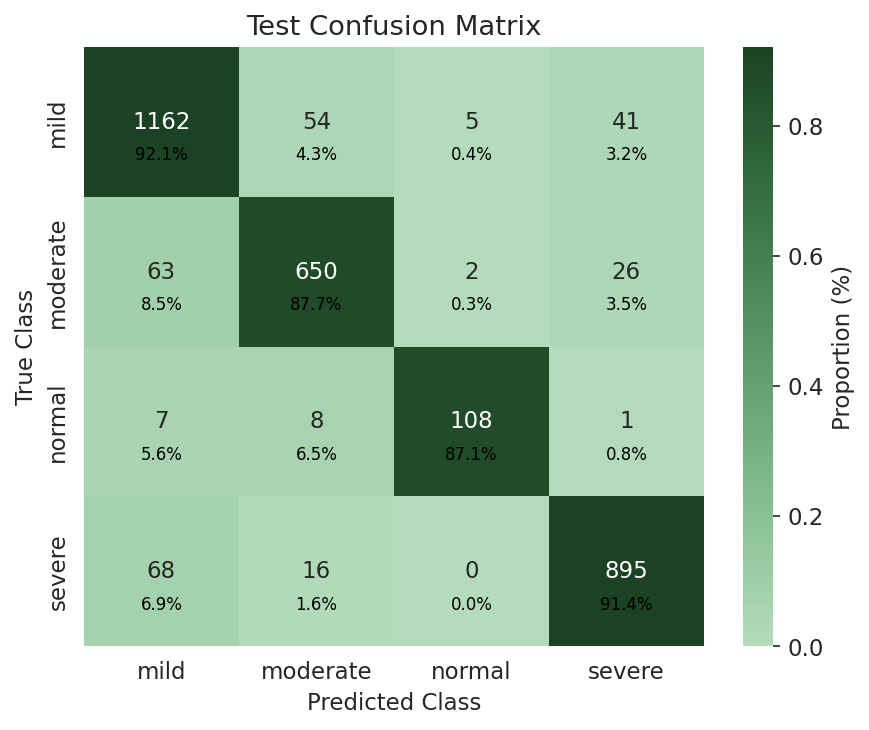

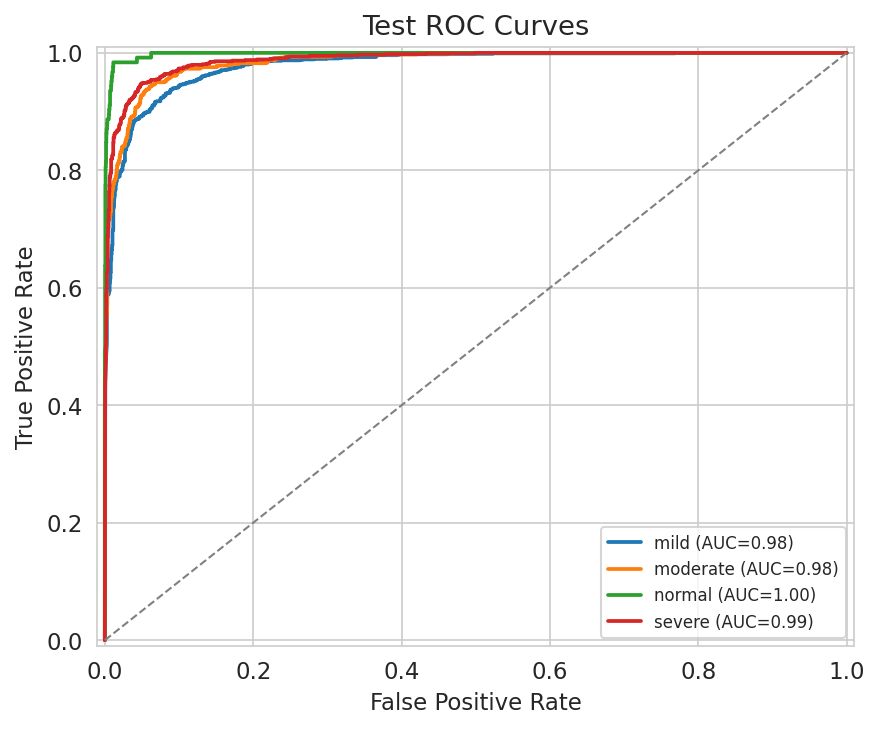

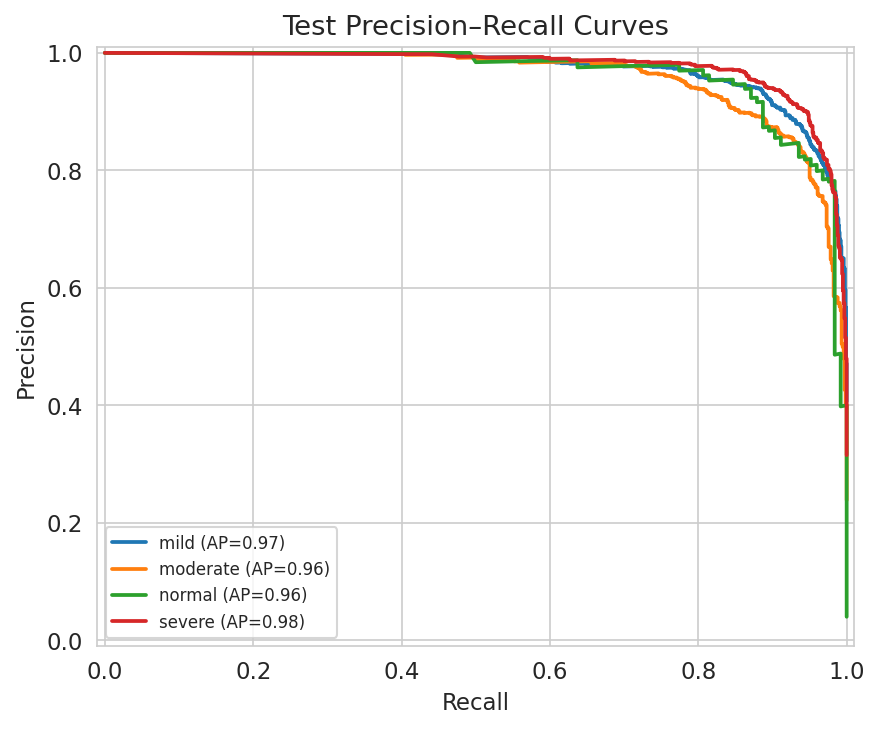

In [ ]:
# ===========================
# 8. GENERATE ALL VISUALS
# ===========================

# Test set visuals
plot_confusion(y_true_test, y_pred_test,   title="Test")
plot_roc      (y_true_test_oh, y_prob_test,  title="Test")
plot_pr       (y_true_test_oh, y_prob_test,  title="Test")

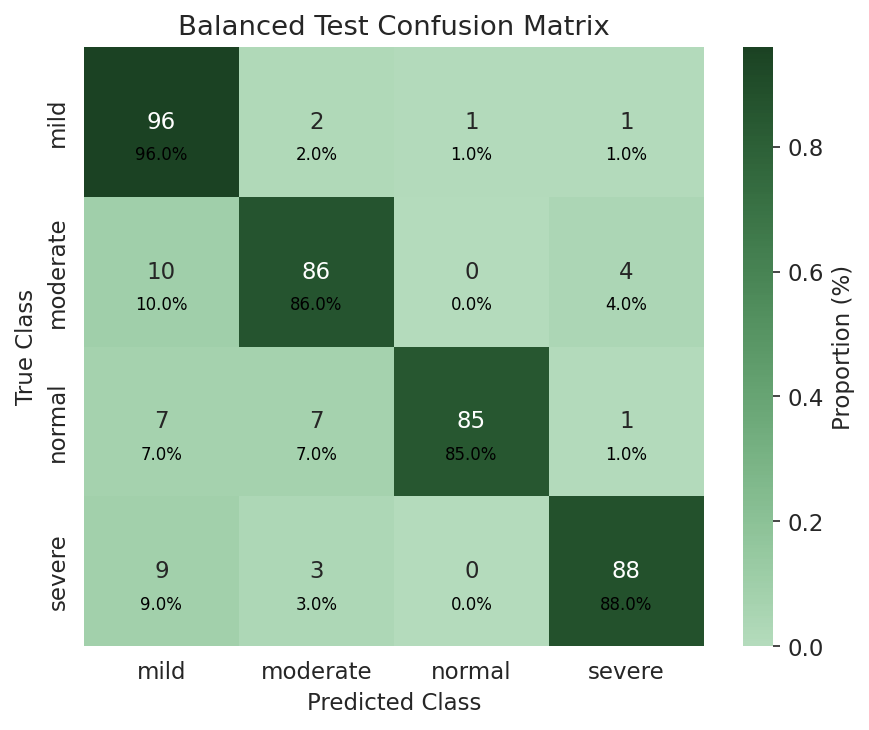

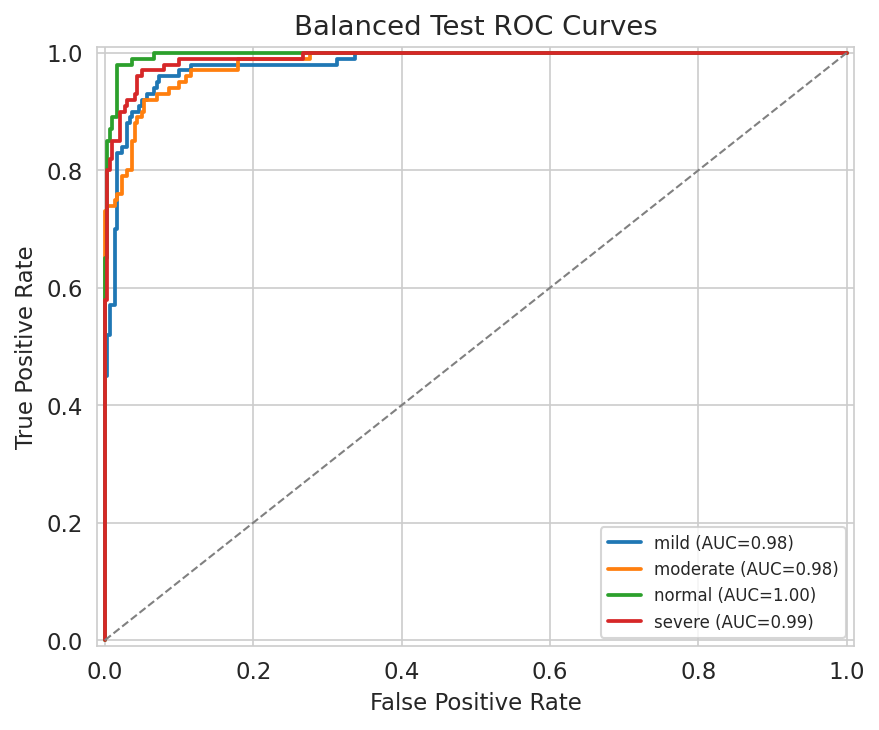

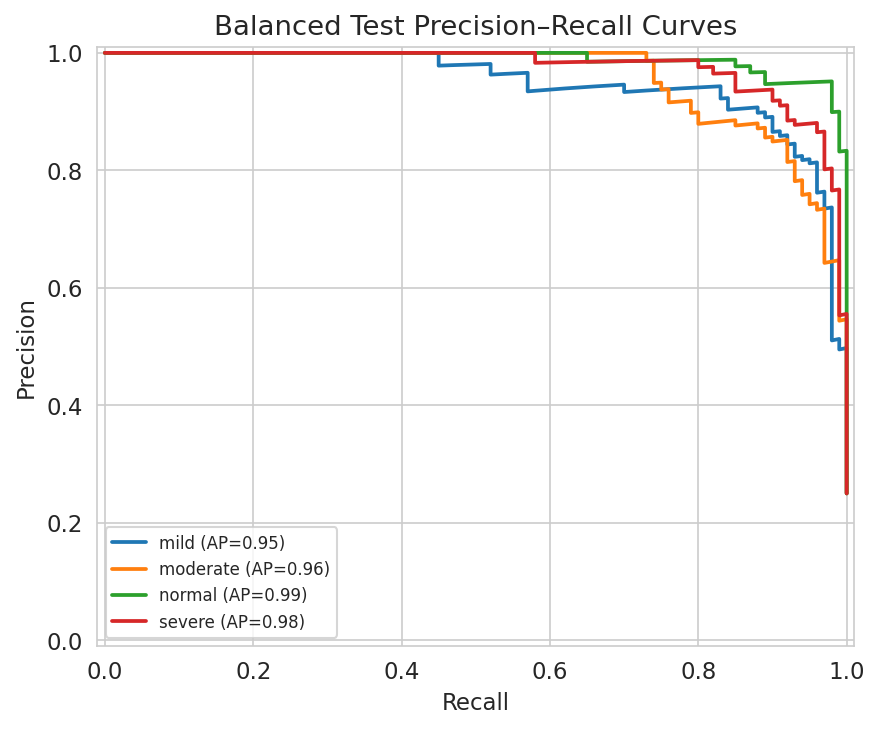

In [ ]:
# Balanced-Test visuals
y_true_bal_oh = np.eye(n_classes)[y_true_bal]
plot_confusion(y_true_bal, y_pred_bal,   title="Balanced Test")
plot_roc      (y_true_bal_oh, y_prob_bal,  title="Balanced Test")
plot_pr       (y_true_bal_oh, y_prob_bal,  title="Balanced Test")